 Musical genre recognition with CNN (by Francisco Rogé Vallone) 

# 1. Import libraries.

In [1]:
import numpy as np
from keras.layers import (BatchNormalization, Conv2D, MaxPooling2D, Dense, Flatten, Dropout)
from keras.models import Sequential
from keras.backend import clear_session
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
from librosa.feature import melspectrogram
from librosa import power_to_db
import matplotlib.pyplot as plt
!pip install pydub

# 2. Download and preprocess the dataset.

In [2]:
def load_data():
  gtzan = tfds.load("gtzan")
  gtzan = list(gtzan['train'])
  audios = []
  labels = []
  for k in range(len(gtzan)):
    audios.append(gtzan[k]["audio"].numpy().astype(np.float32)/np.iinfo(np.int16).max)
    labels.append(gtzan[k]["label"].numpy().astype(np.float32))

  x = np.zeros([len(audios)*6,128,np.ceil(22050*5/1024).astype(int),1])
  y = []
  for k in range(len(audios)):
    for i in range(6):
      spect = melspectrogram(y=audios[k][i*22050:(i+5)*22050], sr=22050, n_fft=2048, hop_length=1024)
      x[i+6*k,:,:,0] = power_to_db(spect, ref=np.max)
      y.append(labels[k])

  y = to_categorical(y)

  x, y = shuffle(x, y)
  x_train = x[:5000]
  y_train = y[:5000]
  x_test = x[5000:]
  y_test = y[5000:]

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/gtzan/1.0.0.incompleteH94HRH/gtzan-train.tfrecord


  0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset gtzan downloaded and prepared to /root/tensorflow_datasets/gtzan/1.0.0. Subsequent calls will reuse this data.


# 3. Build the CNN model.

In [3]:
clear_session()
model = Sequential()
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 106, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 35, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 42, 35, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 33, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 11, 64)       0         
 2D)                                                             
                                                        

# 4. Train the model.

In [4]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=128, verbose=1)

Epoch 1/30
40/40 [==============================] - 181s 4s/step - loss: 1.8577 - accuracy: 0.3830 - val_loss: 6.9945 - val_accuracy: 0.0930
Epoch 2/30
40/40 [==============================] - 168s 4s/step - loss: 1.3651 - accuracy: 0.5620 - val_loss: 4.1938 - val_accuracy: 0.1210
Epoch 3/30
40/40 [==============================] - 168s 4s/step - loss: 1.1555 - accuracy: 0.6474 - val_loss: 1.8426 - val_accuracy: 0.3210
Epoch 4/30
40/40 [==============================] - 168s 4s/step - loss: 0.9648 - accuracy: 0.7122 - val_loss: 1.5015 - val_accuracy: 0.4990
Epoch 5/30
40/40 [==============================] - 168s 4s/step - loss: 0.7931 - accuracy: 0.7792 - val_loss: 1.8022 - val_accuracy: 0.3900
Epoch 6/30
40/40 [==============================] - 168s 4s/step - loss: 0.7058 - accuracy: 0.8082 - val_loss: 1.4825 - val_accuracy: 0.4820
Epoch 7/30
40/40 [==============================] - 168s 4s/step - loss: 0.5344 - accuracy: 0.8658 - val_loss: 1.3792 - val_accuracy: 0.5180
Epoch 8/30
40

# 5. Visualize training results.

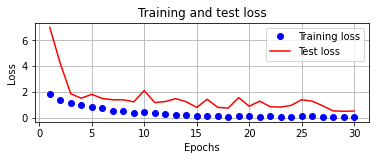

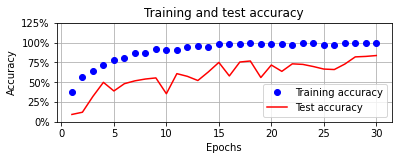

In [5]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()